Problem Set 2: Supervised Learning II

http://cs229.stanford.edu/ps/ps2/ps2.pdf

## 2.6. Spam Classification

### 2.6.a.
Naive Bayes represented as a multinomial event model and Laplace smoothing.

$$
\begin{align}
\phi_{k|y=1} &= \frac{\sum_{i=1}^{m} \sum_{j=1}^{n_i} \boldsymbol{1} \{ x_j^{(i)} = k \wedge y^{(i)} =1 \} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \} n_i + \left| V \right|} \\
\phi_{k|y=0} &= \frac{\sum_{i=1}^{m} \sum_{j=1}^{n_i} \boldsymbol{1} \{ x_j^{(i)} = k \wedge y^{(i)} =0 \} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 0 \} n_i + \left| V \right|} \\
\phi_{y} &= \frac{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \}}{m}
\end{align}
$$

To predict,

$$
\begin{align}
p(y=1|x) &= \frac{p(x|y=1)p(y=1)}{p(x)} \\
              &= \frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0) p(y=0)} \\
              &= \frac{1}{1 + \frac{p(x|y=0) p(y=0)}{p(x|y=1) p(y=1)}} \\
              &= \frac{1}{1 + \mathrm{exp} (\mathrm{log}P(x|y=0) + \mathrm{log}P(y=0) - \mathrm{log}P(x|y=1) - \mathrm{log} P(y=1))}
\end{align}
$$

In [1]:
from svm import *

In [2]:
trainMatrix, tokenlist, trainCategory = readMatrix('MATRIX.TRAIN.400')
print(trainMatrix.shape)
print(len(tokenlist))
print(trainCategory.shape)

(400, 1448)
1448
(400,)


In [3]:
def naive_bayes_train(matrix, category):
    state = {}
    M, N = matrix.shape
    matY0 = matrix[category == -1, :]
    matY1 = matrix[category == 1, :]
    phiY1 = (matY1.sum(axis = 0) + 1) / (np.sum(matY1.sum(axis = 1)) + N)
    phiY0 = (matY0.sum(axis = 0) + 1) / (np.sum(matY0.sum(axis = 1)) + N)
    phi = matY1.shape[0] / (matY0.shape[0] + matY1.shape[0]) 
    state['phiy1'] = phiY1
    state['phiy0'] = phiY0
    state['phi'] = phi
    return state

In [4]:
def naive_bayes_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    
    logXPhi1 = np.sum(np.log(state['phiy1']) * matrix, axis = 1)
    logXPhi0 = np.sum(np.log(state['phiy0']) * matrix, axis = 1)
    logPhi1 = np.log(state['phi'])
    logPhi0 = np.log(1 - state['phi'])
    
    probability = 1.0 / (1 + np.exp(logXPhi0 + logPhi0 - logXPhi1 - logPhi1))
    output[probability > 0.5] = 1
    output[probability <= 0.5] = -1
    return output

In [5]:
def run_naive_bayes(train_file, test_file):
    trainMatrix, tokenlist, trainCategory = readMatrix(train_file)
    testMatrix, tokenlist, testCategory = readMatrix(test_file)

    state = naive_bayes_train(trainMatrix, trainCategory)
    output = naive_bayes_test(testMatrix, state)
    
    error = evaluate(output, testCategory)
    return tokenlist, state, error, trainMatrix.shape[0]

In [6]:
tokenlist, state, error, _ = run_naive_bayes('MATRIX.TRAIN', 'MATRIX.TEST')
print(error)

Error: 0.0163
0.01625


### 2.6.b.

In [7]:
def calculate_indicative_tokens(tokenlist, state, num):
    return np.array(tokenlist)[np.argsort(state['phiy1'] / state['phiy0'])[::-1]][:num]

In [8]:
calculate_indicative_tokens(tokenlist, state, 50)

array(['httpaddr', 'spam', 'unsubscrib', 'ebai', 'valet', 'diploma', 'dvd',
       'websit', 'click', 'lowest', 'numberpx', 'arial', 'helvetica',
       'serif', 'nashua', 'amherst', 'mortgag', 'refin', 'charset',
       'newslett', 'customerservic', 'numberpt', 'iso', 'web', 'lender',
       'numberd', 'loan', 'dailybargainmail', 'coral', 'html', 'unsolicit',
       'www', 'fl', 'holidai', 'equiti', 'tal', 'consolid', 'bachelor',
       'sweepstak', 'subscript', 'mba', 'bonu', 'ae', 'refinanc', 'hover',
       'mime', 'untitl', 'subscrib', 'recur', 'postal'], 
      dtype='<U16')

### 2.6.c.

In [9]:
import glob
files = sorted(glob.glob('./MATRIX.TRAIN.[0-9]*'), key=lambda s: int(s.rsplit('.')[-1]))
print(files)

['./MATRIX.TRAIN.50', './MATRIX.TRAIN.100', './MATRIX.TRAIN.200', './MATRIX.TRAIN.400', './MATRIX.TRAIN.800', './MATRIX.TRAIN.1400']


In [10]:
def multiple_naive_bayes_run():
    errors = []
    train_sizes = []
    for f in files:
        tokenlist, state, error, train_size = run_naive_bayes(f, 'MATRIX.TEST')
        errors.append(error)
        train_sizes.append(train_size)
    return errors, train_sizes

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Error: 0.0387
Error: 0.0262
Error: 0.0262
Error: 0.0187
Error: 0.0175
Error: 0.0163


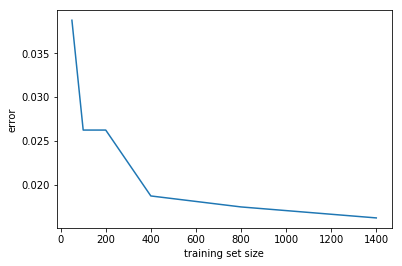

In [12]:
nb_errors, nb_train_sizes = multiple_naive_bayes_run()
plt.plot(nb_train_sizes, nb_errors)
plt.xlabel('training set size')
plt.ylabel('error')

### 2.6.d.

In [13]:
def run_svm(train_file, test_file):
    trainMatrix, tokenlist, trainCategory = readMatrix(train_file)
    testMatrix, tokenlist, testCategory = readMatrix(test_file)

    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)
    
    error = evaluate(output, testCategory)
    return tokenlist, state, error, trainMatrix.shape[0]

In [14]:
def multiple_svm_run():
    errors = []
    train_sizes = []
    for f in files:
        tokenlist, state, error, train_size = run_svm(f, 'MATRIX.TEST')
        errors.append(error)
        train_sizes.append(train_size)
    return errors, train_sizes

Error: 0.0163
Error: 0.0112
Error: 0.0050
Error: 0.0025
Error: 0.0000
Error: 0.0000


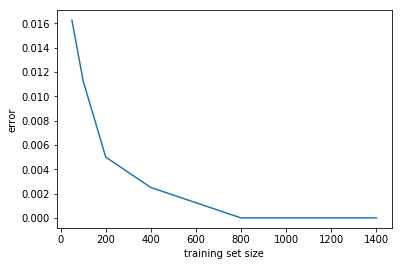

In [15]:
svm_errors, svm_train_sizes = multiple_svm_run()
plt.plot(svm_train_sizes, svm_errors)
plt.xlabel('training set size')
plt.ylabel('error')

### 2.6.e.

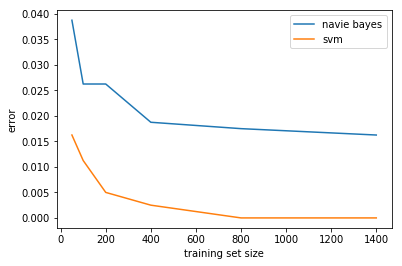

In [16]:
plt.plot(nb_train_sizes, nb_errors, label='navie bayes')
plt.plot(svm_train_sizes, svm_errors, label='svm')
plt.xlabel('training set size')
plt.ylabel('error')
plt.legend()

SVM performs better than Naive Bayes at every training set size.